# Volume Rendering

## Initialization

In [1]:
import os
import numpy
import open3d
import pathlib

import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn

from pytorch3d.io import load_objs_as_meshes
from pytorch3d.structures import Pointclouds, Volumes
from pytorch3d.transforms import so3_exp_map

from pytorch3d.renderer import (
    BlendParams,
    EmissionAbsorptionRaymarcher,
    FoVPerspectiveCameras,
    look_at_view_transform,
    MeshRasterizer,
    MeshRenderer,
    NDCGridRaysampler,
    PointLights,
    RasterizationSettings,
    SoftPhongShader,
    SoftSilhouetteShader,
    VolumeRenderer,
    VolumeSampler,
)


def visualize_point_cloud(point_cloud):
    pcd = open3d.io.read_point_cloud(point_cloud)
    open3d.visualization.draw_geometries([pcd], mesh_show_wireframe=True)


def visualize_point_cloud2(verts, device, renderer):
    d_verts = (verts).to(device)
    rgb = torch.ones_like(d_verts).to(device)
    point_cloud = Pointclouds(points=[verts], features=[rgb])
    images = renderer(point_cloud)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.axis("off")


def visualize_point_cloud2_save(verts, device, renderer, index):
    d_verts = (verts).to(device)
    rgb = torch.ones_like(d_verts).to(device)
    point_cloud = Pointclouds(points=[verts], features=[rgb])
    images = renderer(point_cloud)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.axis("off")
    plt.savefig(f"./out/image{index}.png")


def visualize_mesh(mesh):
    print(f"Visualizing the mesh {mesh} using open3D")
    mesh = open3d.io.read_triangle_mesh(mesh, enable_post_processing=True)
    open3d.visualization.draw_geometries([mesh], mesh_show_wireframe=True, mesh_show_back_face=True)


def delete_from_disk(path: pathlib.Path):
    if path.is_file() or path.is_symlink():
        path.unlink()
        return
    for p in path.iterdir():
        delete_from_disk(p)
    path.rmdir()


def image_grid(images, rows=None, cols=None, fill: bool = True, show_axes: bool = False, rgb: bool = True):
    """
    A util function for plotting a grid of images.

    Args:
        images: (N, H, W, 4) array of RGBA images
        rows: number of rows in the grid
        cols: number of columns in the grid
        fill: boolean indicating if the space between images should be filled
        show_axes: boolean indicating if the axes of the plots should be visible
        rgb: boolean, If True, only RGB channels are plotted.
            If False, only the alpha channel is plotted.

    Returns:
        None
    """
    if (rows is None) != (cols is None):
        raise ValueError("Specify either both rows and cols or neither.")

    if rows is None:
        rows = len(images)
        cols = 1

    gridspec_kw = {"wspace": 0.0, "hspace": 0.0} if fill else {}
    fig, axarr = plt.subplots(rows, cols, gridspec_kw=gridspec_kw, figsize=(15, 9))
    bleed = 0
    fig.subplots_adjust(left=bleed, bottom=bleed, right=(1 - bleed), top=(1 - bleed))

    for ax, im in zip(axarr.ravel(), images):
        if rgb:
            # only render RGB channels
            ax.imshow(im[..., :3])
        else:
            # only render Alpha channel
            ax.imshow(im[..., 3])
        if not show_axes:
            ax.set_axis_off()


out_path = os.path.abspath("./out")
if os.path.isdir(out_path):
    delete_from_disk(pathlib.Path(out_path))
os.mkdir(out_path)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Multinomial Ray Sampler

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

num_views: int = 10
azimuth_range: float = 180
elev = torch.linspace(0, 0, num_views)  # keep constant
azim = torch.linspace(-azimuth_range, azimuth_range, num_views) + 180.0
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

image_size = 64
volume_extent_world = 3.0
raysampler = NDCGridRaysampler(
    image_width=image_size,
    image_height=image_size,
    n_pts_per_ray=50,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

ray_bundle = raysampler(cameras)

print(f"ray_bundle origins tensor shape = {ray_bundle.origins.shape}")
print(f"ray_bundle directions shape = {ray_bundle.directions.shape}")
print(f"ray_bundle lengths = {ray_bundle.lengths.shape}")
print(f"ray_bundle xys shape = {ray_bundle.xys.shape}")
torch.save({"ray_bundle": ray_bundle}, f"{out_path}/ray_sampling.pt")

ray_bundle origins tensor shape = torch.Size([10, 64, 64, 3])
ray_bundle directions shape = torch.Size([10, 64, 64, 3])
ray_bundle lengths = torch.Size([10, 64, 64, 50])
ray_bundle xys shape = torch.Size([10, 64, 64, 2])


## Volume Sampler

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

checkpoint = torch.load(f"{out_path}/ray_sampling.pt")
ray_bundle = checkpoint.get("ray_bundle")

batch_size = 10
densities = torch.zeros([batch_size, 1, 64, 64, 64]).to(device)
colors = torch.zeros(batch_size, 3, 64, 64, 64).to(device)
voxel_size = 0.1

volumes = Volumes(densities=densities, features=colors, voxel_size=voxel_size)

volume_sampler = VolumeSampler(volumes=volumes, sample_mode="bilinear")
rays_densities, rays_features = volume_sampler(ray_bundle)

print(f"rays_densities shape = {rays_densities.shape}")
print(f"rays_features shape = {rays_features.shape}")

torch.save({"rays_densities": rays_densities, "rays_features": rays_features}, f"{out_path}/volume_sampling.pt")

rays_densities shape = torch.Size([10, 64, 64, 50, 1])
rays_features shape = torch.Size([10, 64, 64, 50, 3])


C:\Users\dkiva\AppData\Local\Temp\ipykernel_34616\638029205.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{out_path}/ray_sampling.pt")


## Ray Marcher

In [4]:
checkpoint = torch.load(f'{out_path}/volume_sampling.pt')
rays_densities = checkpoint.get('rays_densities')
rays_features = checkpoint.get('rays_features')

ray_marcher = EmissionAbsorptionRaymarcher()
image_features = ray_marcher(rays_densities = rays_densities, rays_features = rays_features)

print(f'image_features shape = {image_features.shape}')

image_features shape = torch.Size([10, 64, 64, 4])


C:\Users\dkiva\AppData\Local\Temp\ipykernel_34616\939332146.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f'{out_path}/volume_sampling.pt')


## Volume Render

In [5]:
def generate_cow_renders(num_views: int = 40, azimuth_range: float = 180):
    """
    This function generates `num_views` renders of a cow mesh.
    The renders are generated from viewpoints sampled at uniformly distributed
    azimuth intervals. The elevation is kept constant so that the camera's
    vertical position coincides with the equator.

    For a more detailed explanation of this code, please refer to the
    docs/tutorials/fit_textured_mesh.ipynb notebook.

    Args:
        num_views: The number of generated renders.
        data_dir: The folder that contains the cow mesh files. If the cow mesh
            files do not exist in the folder, this function will automatically
            download them.

    Returns:
        cameras: A batch of `num_views` `FoVPerspectiveCameras` from which the
            images are rendered.
        images: A tensor of shape `(num_views, height, width, 3)` containing
            the rendered images.
        silhouettes: A tensor of shape `(num_views, height, width)` containing
            the rendered silhouettes.
    """

    # set the paths
    spot_dir = os.path.abspath("./spot")

    # Setup
    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        torch.cuda.set_device(device)
    else:
        device = torch.device("cpu")

    # Load obj file
    obj_filename = os.path.join(spot_dir, "spot.obj")
    mesh = load_objs_as_meshes([obj_filename], device=device)

    # We scale normalize and center the target mesh to fit in a sphere of radius 1
    # centered at (0,0,0). (scale, center) will be used to bring the predicted mesh
    # to its original center and scale.  Note that normalizing the target mesh,
    # speeds up the optimization but is not necessary!
    verts = mesh.verts_packed()
    N = verts.shape[0]
    center = verts.mean(0)
    scale = max((verts - center).abs().max(0)[0])
    mesh.offset_verts_(-(center.expand(N, 3)))
    mesh.scale_verts_((1.0 / float(scale)))

    # Get a batch of viewing angles.
    elev = torch.linspace(0, 0, num_views)  # keep constant
    azim = torch.linspace(-azimuth_range, azimuth_range, num_views) + 180.0

    # Place a point light in front of the object. As mentioned above, the front of
    # the cow is facing the -z direction.
    lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

    # Initialize an OpenGL perspective camera that represents a batch of different
    # viewing angles. All the cameras helper methods support mixed type inputs and
    # broadcasting. So we can view the camera from the a distance of dist=2.7, and
    # then specify elevation and azimuth angles for each viewpoint as tensors.
    R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
    cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

    # Define the settings for rasterization and shading. Here we set the output
    # image to be of size 128X128. As we are rendering images for visualization
    # purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to
    # rasterize_meshes.py for explanations of these parameters.  We also leave
    # bin_size and max_faces_per_bin to their default values of None, which sets
    # their values using heuristics and ensures that the faster coarse-to-fine
    # rasterization method is used.  Refer to docs/notes/renderer.md for an
    # explanation of the difference between naive and coarse-to-fine rasterization.
    raster_settings = RasterizationSettings(image_size=128, blur_radius=0.0, faces_per_pixel=1)

    # Create a Phong renderer by composing a rasterizer and a shader. The textured
    # Phong shader will interpolate the texture uv coordinates for each vertex,
    # sample from a texture image and apply the Phong lighting model
    blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(0.0, 0.0, 0.0))
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings),
        shader=SoftPhongShader(device=device, cameras=cameras, lights=lights, blend_params=blend_params),
    )

    # Create a batch of meshes by repeating the cow mesh and associated textures.
    # Meshes has a useful `extend` method which allows us do this very easily.
    # This also extends the textures.
    meshes = mesh.extend(num_views)

    # Render the cow mesh from each viewing angle
    target_images = renderer(meshes, cameras=cameras, lights=lights)

    # Rasterization settings for silhouette rendering
    sigma = 1e-4
    raster_settings_silhouette = RasterizationSettings(image_size=128, blur_radius=numpy.log(1.0 / 1e-4 - 1.0) * sigma, faces_per_pixel=50)

    # Silhouette renderer
    renderer_silhouette = MeshRenderer(
        rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings_silhouette),
        shader=SoftSilhouetteShader(),
    )

    # Render silhouette images.  The 3rd channel of the rendering output is
    # the alpha/silhouette channel
    silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=lights)

    # binary silhouettes
    silhouette_binary = (silhouette_images[..., 3] > 1e-4).float()

    return cameras, target_images[..., :3], silhouette_binary

Iteration 00000: color_err = 2.73e-01 mask_err = 5.70e-01
Iteration 00100: color_err = 4.97e-03 mask_err = 1.41e-02
Iteration 00200: color_err = 4.23e-03 mask_err = 1.07e-02
Decreasing LR 10-fold ...
Generating rotating volume ...
Saving animation


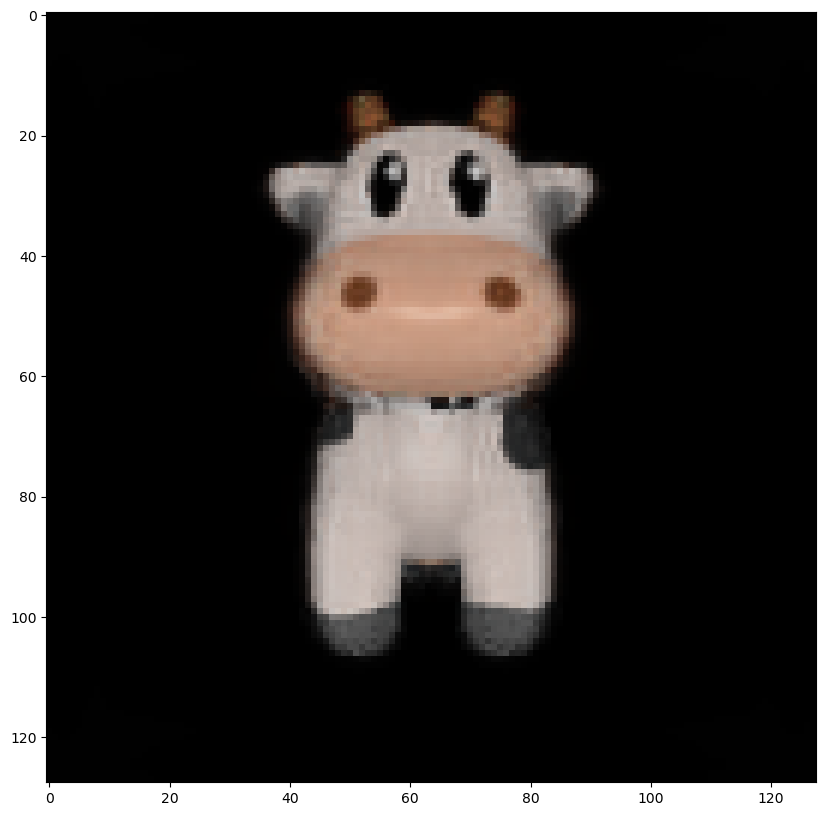

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40)

render_size = 128
volume_extent_world = 3.0

raysampler = NDCGridRaysampler(
    image_width=render_size,
    image_height=render_size,
    n_pts_per_ray=150,
    min_depth=0.1,
    max_depth=volume_extent_world,
)

raymarcher = EmissionAbsorptionRaymarcher()
renderer = VolumeRenderer(
    raysampler=raysampler,
    raymarcher=raymarcher,
)


class VolumeModel(torch.nn.Module):
    def __init__(self, renderer, volume_size=[64] * 3, voxel_size=0.1):
        super().__init__()
        self.log_densities = torch.nn.Parameter(-4.0 * torch.ones(1, *volume_size))
        self.log_colors = torch.nn.Parameter(torch.zeros(3, *volume_size))
        self._voxel_size = voxel_size
        self._renderer = renderer

    def forward(self, cameras):
        batch_size = cameras.R.shape[0]

        densities = torch.sigmoid(self.log_densities)
        colors = torch.sigmoid(self.log_colors)

        volumes = Volumes(
            densities=densities[None].expand(batch_size, *self.log_densities.shape),
            features=colors[None].expand(batch_size, *self.log_colors.shape),
            voxel_size=self._voxel_size,
        )
        return self._renderer(cameras=cameras, volumes=volumes)[0]


def huber(x, y, scaling=0.1):
    diff_sq = (x - y) ** 2
    loss = ((1 + diff_sq / (scaling**2)).clamp(1e-4).sqrt() - 1) * float(scaling)
    return loss


target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

volume_size = 128
volume_model = VolumeModel(
    renderer,
    volume_size=[volume_size] * 3,
    voxel_size=volume_extent_world / volume_size,
).to(device)

lr = 0.1
optimizer = torch.optim.Adam(volume_model.parameters(), lr=lr)

batch_size = 10
n_iter = 300
for iteration in range(n_iter):

    if iteration == round(n_iter * 0.75):
        print("Decreasing LR 10-fold ...")
        optimizer = torch.optim.Adam(volume_model.parameters(), lr=lr * 0.1)

    optimizer.zero_grad()
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R=target_cameras.R[batch_idx],
        T=target_cameras.T[batch_idx],
        znear=target_cameras.znear[batch_idx],
        zfar=target_cameras.zfar[batch_idx],
        aspect_ratio=target_cameras.aspect_ratio[batch_idx],
        fov=target_cameras.fov[batch_idx],
        device=device,
    )

    rendered_images, rendered_silhouettes = volume_model(batch_cameras).split([3, 1], dim=-1)

    sil_err = (
        huber(
            rendered_silhouettes[..., 0],
            target_silhouettes[batch_idx],
        )
        .abs()
        .mean()
    )

    color_err = (
        huber(
            rendered_images,
            target_images[batch_idx],
        )
        .abs()
        .mean()
    )

    loss = color_err + sil_err
    if iteration % 100 == 0:
        print(f"Iteration {iteration:05d}:" + f" color_err = {float(color_err):1.2e}" + f" mask_err = {float(sil_err):1.2e}")

    # Take the optimization step.
    loss.backward()
    optimizer.step()


def generate_rotating_volume(volume_model, n_frames=50):
    logRs = torch.zeros(n_frames, 3, device=device)
    logRs[:, 1] = torch.linspace(0.0, 2.0 * 3.14, n_frames, device=device)
    Rs = so3_exp_map(logRs)
    Ts = torch.zeros(n_frames, 3, device=device)
    Ts[:, 2] = 2.7
    frames = []
    print("Generating rotating volume ...")
    for R, T in zip(Rs, Ts):
        camera = FoVPerspectiveCameras(
            R=R[None],
            T=T[None],
            znear=target_cameras.znear[0],
            zfar=target_cameras.zfar[0],
            aspect_ratio=target_cameras.aspect_ratio[0],
            fov=target_cameras.fov[0],
            device=device,
        )
        frames.append(volume_model(camera)[..., :3].clamp(0.0, 1.0))
    return torch.cat(frames)


with torch.no_grad():
    rotating_volume_frames = generate_rotating_volume(volume_model, n_frames=7 * 4 * 10)

# image_grid(rotating_volume_frames.clamp(0.0, 1.0).cpu().numpy(), rows=4, cols=7, rgb=True, fill=True)
# plt.savefig(f"{out_path}/rotating_volume.png")
# plt.show()
# plt.close()

print("Saving animation")
frames = []
fig = plt.figure(figsize=(10, 10))
for frame in rotating_volume_frames:
    frames.append([plt.imshow(frame.clamp(0.0, 1.0).cpu().numpy(), animated=True)])

anim = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
anim.save(os.path.join(out_path, "rotating_volumet_animation.mp4"))
